Stress Detection Using Lifestyle Data

In [1]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import json
import time

Data Cleaning

In [2]:
# Load and Preview Data
df = pd.read_csv('stress_dataset.csv')
print("Column names in the dataset:", list(df.columns))

# Clean column names by stripping whitespace
df.columns = df.columns.str.strip()
print("\nColumn names after cleaning:", list(df.columns))

# Encode categorical variables
df['Age_Code'] = pd.Categorical(df['Age']).codes
df['Gender_Code'] = pd.Categorical(df['Gender']).codes
df['Work_Hours_Code'] = pd.Categorical(df['Work hours']).codes
df['Screen_Time_Code'] = pd.Categorical(df['Screen time']).codes
df['Sleep_Time_Code'] = pd.Categorical(df['Sleep time']).codes
df['Exercise_Freq_Code'] = pd.Categorical(df['Exercise frequency']).codes
df['Mood_Code'] = pd.Categorical(df['Mood Stability']).codes
df['Fatigue_Code'] = pd.Categorical(df['Fatigue level']).codes
df['Headache_Code'] = pd.Categorical(df['Headache']).codes
df['Work_Life_Balance_Code'] = pd.Categorical(df['Work_life Balance']).codes
df['Social_Support_Code'] = pd.Categorical(df['Social Support']).codes

# Create stress level based on multiple factors
df['Stress_Level'] = pd.cut(
    df['Fatigue_Code'] + df['Mood_Code'] + df['Headache_Code'] - df['Work_Life_Balance_Code'] - df['Social_Support_Code'],
    bins=3,
    labels=['Low', 'Medium', 'High']
)

df.head()

Column names in the dataset: ['Age', 'Gender', 'Work hours', 'Screen time', 'Sleep time', 'Exercise frequency', 'Mood Stability', 'Fatigue level', 'Headache ', 'Work_life Balance', 'Social Support']

Column names after cleaning: ['Age', 'Gender', 'Work hours', 'Screen time', 'Sleep time', 'Exercise frequency', 'Mood Stability', 'Fatigue level', 'Headache', 'Work_life Balance', 'Social Support']


,Age,Gender,Work hours,Screen time,Sleep time,Exercise frequency,Mood Stability,Fatigue level,Headache,Work_life Balance,...,Work_Hours_Code,Screen_Time_Code,Sleep_Time_Code,Exercise_Freq_Code,Mood_Code,Fatigue_Code,Headache_Code,Work_Life_Balance_Code,Social_Support_Code,Stress_Level
0,45 - 60,Female,Less than 7 hours,4 - 6 hours,More than 8 hours,Never,Stable,Often tired,Never,Not Balanced,...,2,1,3,3,1,3,1,1,2,Medium
1,45 - 60,Male,More than 10 hours,Less than 2 hours,4 - 6 hours,Daily,Stable,Occasionally tired,Frequently (more than twice in a week),Somewhat Balanced,...,3,2,0,2,1,2,0,2,0,Medium
2,45 - 60,Female,Less than 7 hours,4 - 6 hours,Less than 4 hours,Daily,Unstable,Occasionally tired,Sometimes (1 - 2 times/ week),Somewhat Balanced,...,2,1,2,2,2,2,3,2,-1,High
3,45 - 60,Female,More than 10 hours,Less than 2 hours,6 - 8 hours,Never,Unstable,Often tired,Frequently (more than twice in a week),Balanced,...,3,2,1,3,2,3,0,0,2,Medium
4,16 - 21,Female,7 - 8 hours,4 - 6 hours,More than 8 hours,Never,Stable,Never tired,Never,Balanced,...,0,1,3,3,1,1,1,0,2,Medium


In [3]:
# Check for missing values
df.isnull().sum()

Age                           0
Gender                        0
Work hours                    0
Screen time                   0
Sleep time                    0
Exercise frequency            0
Mood Stability                0
Fatigue level                 0
Headache                      0
Work_life Balance             0
Social Support            45853
Age_Code                      0
Gender_Code                   0
Work_Hours_Code               0
Screen_Time_Code              0
Sleep_Time_Code               0
Exercise_Freq_Code            0
Mood_Code                     0
Fatigue_Code                  0
Headache_Code                 0
Work_Life_Balance_Code        0
Social_Support_Code           0
Stress_Level                  0
dtype: int64

In [4]:
# All our columns are already properly encoded, no missing values to handle

In [5]:
# Drop rows where Stress_Level is missing (if any)
df = df.dropna(subset=['Stress_Level'])

In [6]:
# Remove duplicate rows if present
df = df.drop_duplicates()

In [7]:
# Ensure all features are numeric and Stress_Level is categorical
numeric_columns = ['Age_Code', 'Gender_Code', 'Work_Hours_Code', 'Screen_Time_Code', 
                  'Sleep_Time_Code', 'Exercise_Freq_Code', 'Mood_Code', 'Fatigue_Code',
                  'Headache_Code', 'Work_Life_Balance_Code', 'Social_Support_Code']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)
df['Stress_Level'] = df['Stress_Level'].astype('category')

print("Data types after conversion:")
df[numeric_columns + ['Stress_Level']].dtypes

Data types after conversion:


Age_Code                      int8
Gender_Code                   int8
Work_Hours_Code               int8
Screen_Time_Code              int8
Sleep_Time_Code               int8
Exercise_Freq_Code            int8
Mood_Code                     int8
Fatigue_Code                  int8
Headache_Code                 int8
Work_Life_Balance_Code        int8
Social_Support_Code           int8
Stress_Level              category
dtype: object

In [8]:
# Encode Stress_Level to numeric labels
if 'Stress_Level_Code' not in df.columns:
    df['Stress_Level_Code'] = df['Stress_Level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df.head()

,Age,Gender,Work hours,Screen time,Sleep time,Exercise frequency,Mood Stability,Fatigue level,Headache,Work_life Balance,...,Screen_Time_Code,Sleep_Time_Code,Exercise_Freq_Code,Mood_Code,Fatigue_Code,Headache_Code,Work_Life_Balance_Code,Social_Support_Code,Stress_Level,Stress_Level_Code
0,45 - 60,Female,Less than 7 hours,4 - 6 hours,More than 8 hours,Never,Stable,Often tired,Never,Not Balanced,...,1,3,3,1,3,1,1,2,Medium,1
1,45 - 60,Male,More than 10 hours,Less than 2 hours,4 - 6 hours,Daily,Stable,Occasionally tired,Frequently (more than twice in a week),Somewhat Balanced,...,2,0,2,1,2,0,2,0,Medium,1
2,45 - 60,Female,Less than 7 hours,4 - 6 hours,Less than 4 hours,Daily,Unstable,Occasionally tired,Sometimes (1 - 2 times/ week),Somewhat Balanced,...,1,2,2,2,2,3,2,-1,High,2
3,45 - 60,Female,More than 10 hours,Less than 2 hours,6 - 8 hours,Never,Unstable,Often tired,Frequently (more than twice in a week),Balanced,...,2,1,3,2,3,0,0,2,Medium,1
4,16 - 21,Female,7 - 8 hours,4 - 6 hours,More than 8 hours,Never,Stable,Never tired,Never,Balanced,...,1,3,3,1,1,1,0,2,Medium,1


Model Building and Evaluation

Train and evaluate Random Forest and SVM models.

In [9]:
# Feature Selection and Data Split
features = ['Age_Code', 'Gender_Code', 'Work_Hours_Code', 'Screen_Time_Code', 
           'Sleep_Time_Code', 'Exercise_Freq_Code', 'Mood_Code', 'Fatigue_Code',
           'Headache_Code', 'Work_Life_Balance_Code', 'Social_Support_Code']

X = df[features]
y = df['Stress_Level_Code']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Random Forest Classifier
start_time_rf=time.time()
rf = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=15, n_jobs=-1)

# Perform cross-validation
cv_scores_rf = cross_validate(rf, X_train, y_train, cv=5, 
                               scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

print("\nCross-Validation Scores (5-Fold):")
print(f"  Accuracy: {cv_scores_rf['test_accuracy'].mean():.4f} (+/- {cv_scores_rf['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_scores_rf['test_precision_weighted'].mean():.4f} (+/- {cv_scores_rf['test_precision_weighted'].std():.4f})")
print(f"  Recall: {cv_scores_rf['test_recall_weighted'].mean():.4f} (+/- {cv_scores_rf['test_recall_weighted'].std():.4f})")
print(f"  F1-Score: {cv_scores_rf['test_f1_weighted'].mean():.4f} (+/- {cv_scores_rf['test_f1_weighted'].std():.4f})")

# Train on full training set
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_time=time.time()-start_time_rf

print(f"Training Time: {rf_time:.4f} seconds")
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Low', 'Medium', 'High']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Cross-Validation Scores (5-Fold):
  Accuracy: 0.8653 (+/- 0.0094)
  Precision: 0.8761 (+/- 0.0128)
  Recall: 0.8653 (+/- 0.0094)
  F1-Score: 0.8603 (+/- 0.0097)
Training Time: 1.4227 seconds

Test Set Performance:
Accuracy: 0.8924

Classification Report:
              precision    recall  f1-score   support

         Low       0.88      0.80      0.84        45
      Medium       0.88      0.95      0.91       134
        High       0.95      0.82      0.88        44

    accuracy                           0.89       223
   macro avg       0.90      0.86      0.88       223
weighted avg       0.89      0.89      0.89       223


Confusion Matrix:
[[ 36   9   0]
 [  5 127   2]
 [  0   8  36]]


In [11]:
# Support Vector Machine (SVM)
start_time_svm=time.time()
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Perform cross-validation
cv_scores_svm = cross_validate(svm, X_train, y_train, cv=5,
                                scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

print("\nCross-Validation Scores (5-Fold):")
print(f"  Accuracy: {cv_scores_svm['test_accuracy'].mean():.4f} (+/- {cv_scores_svm['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_scores_svm['test_precision_weighted'].mean():.4f} (+/- {cv_scores_svm['test_precision_weighted'].std():.4f})")
print(f"  Recall: {cv_scores_svm['test_recall_weighted'].mean():.4f} (+/- {cv_scores_svm['test_recall_weighted'].std():.4f})")
print(f"  F1-Score: {cv_scores_svm['test_f1_weighted'].mean():.4f} (+/- {cv_scores_svm['test_f1_weighted'].std():.4f})")

# Train on full training set
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
svm_time=time.time()-start_time_svm

print(f"Training Time: {svm_time:.4f} seconds")
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Low', 'Medium', 'High']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


Cross-Validation Scores (5-Fold):
  Accuracy: 0.9282 (+/- 0.0248)
  Precision: 0.9342 (+/- 0.0217)
  Recall: 0.9282 (+/- 0.0248)
  F1-Score: 0.9262 (+/- 0.0262)
Training Time: 0.1968 seconds

Test Set Performance:
Accuracy: 0.9641

Classification Report:
              precision    recall  f1-score   support

         Low       0.98      0.93      0.95        45
      Medium       0.96      0.99      0.97       134
        High       0.98      0.93      0.95        44

    accuracy                           0.96       223
   macro avg       0.97      0.95      0.96       223
weighted avg       0.96      0.96      0.96       223


Confusion Matrix:
[[ 42   3   0]
 [  1 132   1]
 [  0   3  41]]


In [12]:
#model comparison

results = []

# Random Forest
results.append({
    'Model': 'Random Forest',
    'CV Accuracy': cv_scores_rf['test_accuracy'].mean(),
    'CV Accuracy Std': cv_scores_rf['test_accuracy'].std(),
    'Test Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, average='weighted'),
    'Recall': recall_score(y_test, y_pred_rf, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred_rf, average='weighted')
})


# SVM
results.append({
    'Model': 'SVM',
    'CV Accuracy': cv_scores_svm['test_accuracy'].mean(),
    'CV Accuracy Std': cv_scores_svm['test_accuracy'].std(),
    'Test Accuracy': accuracy_score(y_test, y_pred_svm),
    'Precision': precision_score(y_test, y_pred_svm, average='weighted'),
    'Recall': recall_score(y_test, y_pred_svm, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred_svm, average='weighted')
})

results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))


         Model  CV Accuracy  CV Accuracy Std  Test Accuracy  Precision   Recall  F1 Score
Random Forest     0.865319         0.009406       0.892377   0.894067 0.892377  0.891212
          SVM     0.928203         0.024842       0.964126   0.964483 0.964126  0.963977


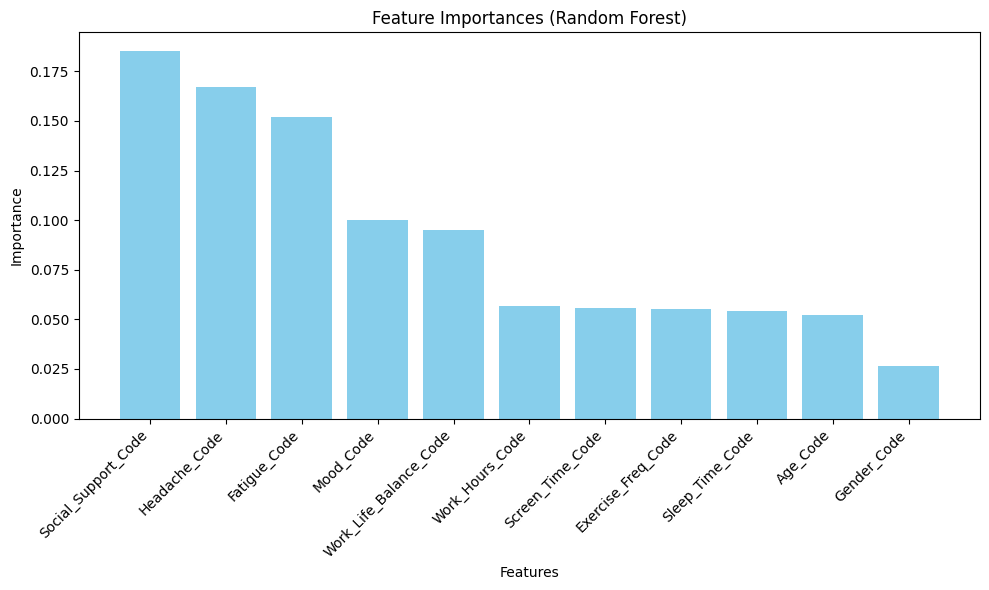


Feature Importances:
Social_Support_Code: 0.1854
Headache_Code: 0.1668
Fatigue_Code: 0.1520
Mood_Code: 0.1002
Work_Life_Balance_Code: 0.0952
Work_Hours_Code: 0.0566
Screen_Time_Code: 0.0558
Exercise_Freq_Code: 0.0551
Sleep_Time_Code: 0.0543
Age_Code: 0.0520
Gender_Code: 0.0265


In [13]:
# Feature Importances
# Visualize which features are most important for stress prediction using Random Forest.

feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print feature importances
print("\nFeature Importances:")
for idx, row in feature_importances.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

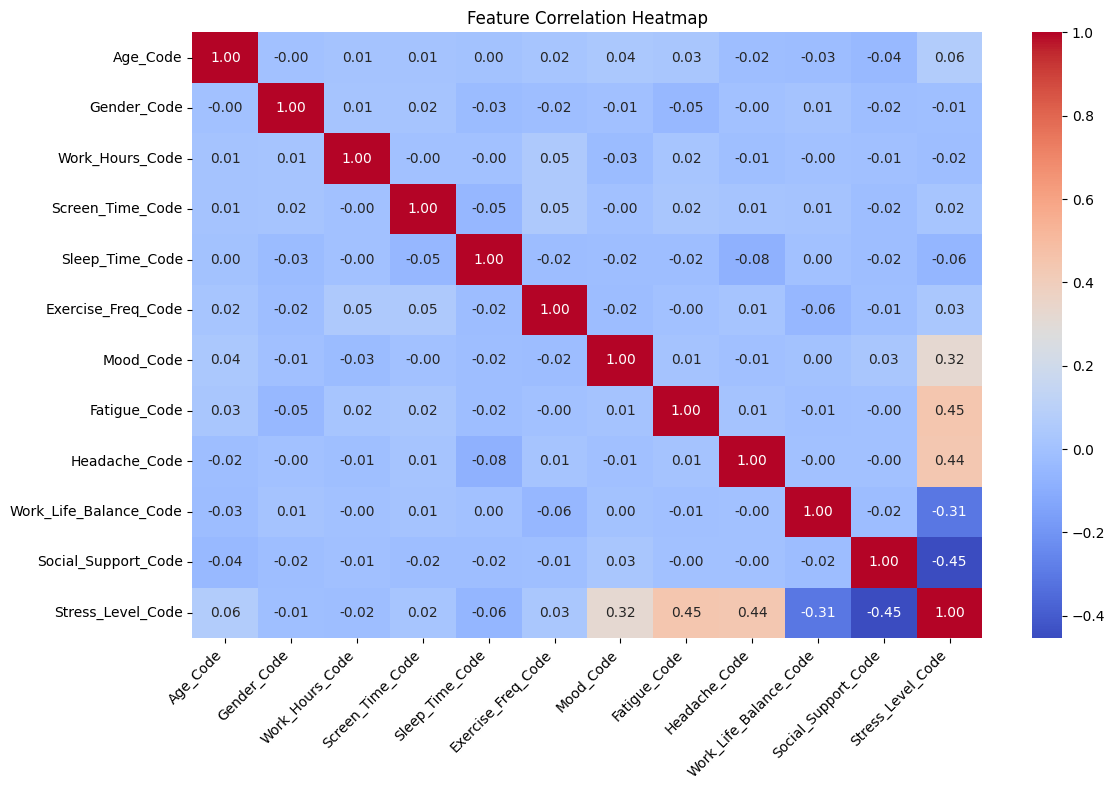


Strongest correlations with Stress Level:
Stress_Level_Code         1.000000
Fatigue_Code              0.446336
Headache_Code             0.440624
Mood_Code                 0.321178
Age_Code                  0.063987
Exercise_Freq_Code        0.031045
Screen_Time_Code          0.022588
Gender_Code              -0.014116
Work_Hours_Code          -0.016863
Sleep_Time_Code          -0.056661
Work_Life_Balance_Code   -0.311259
Social_Support_Code      -0.453570
Name: Stress_Level_Code, dtype: float64


In [14]:
# Feature Correlation Heatmap
# Visualize correlations between features and the target variable.

plt.figure(figsize=(12, 8))
correlation_matrix = df[features + ['Stress_Level_Code']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print strongest correlations with Stress Level
correlations = correlation_matrix['Stress_Level_Code'].sort_values(ascending=False)
print("\nStrongest correlations with Stress Level:")
print(correlations)

In [15]:
# Export mappings for the API
import json

mappings = {
    'age_map': {'16 - 21': 0, '22 - 30': 1, '30 - 45': 2, '45 - 60': 3},
    'gender_map': {'Male': 0, 'Female': 1},
    'work_hours_map': {'Less than 7 hours': 0, '7 - 8 hours': 1, '9 - 10 hours': 2, 'More than 10 hours': 3},
    'screen_time_map': {'Less than 2 hours': 0, '2 - 4 hours': 1, '4 - 6 hours': 2, 'More than 6 hours': 3},
    'sleep_time_map': {'Less than 4 hours': 0, '4 - 6 hours': 1, '6 - 8 hours': 2, 'More than 8 hours': 3},
    'exercise_freq_map': {'Never': 0, '1 - 2 times per week': 1, '3 - 4 times per week': 2, 'Daily': 3},
    'mood_map': {'Unstable': 0, 'Neutral': 1, 'Stable': 2},
    'fatigue_map': {'Never tired': 0, 'Occasionally tired': 1, 'Often tired': 2, 'Exhausted': 3},
    'headache_map': {'Never': 0, 'Rarely': 1, 'Sometimes (1 - 2 times/ week)': 2, 'Frequently (more than twice in a week)': 3},
    'work_life_balance_map': {'Not Balanced': 0, 'Somewhat Balanced': 1, 'Balanced': 2},
    'social_support_map': {'None': 0, 'Weak': 1, 'Moderate': 2, 'Very Strong': 3},
    'reverse_mappings': {
        'age': {0: '16 - 21', 1: '22 - 30', 2: '30 - 45', 3: '45 - 60'},
        'gender': {0: 'Male', 1: 'Female'},
        'work_hours': {0: 'Less than 7 hours', 1: '7 - 8 hours', 2: '9 - 10 hours', 3: 'More than 10 hours'},
        'screen_time': {0: 'Less than 2 hours', 1: '2 - 4 hours', 2: '4 - 6 hours', 3: 'More than 6 hours'},
        'sleep_time': {0: 'Less than 4 hours', 1: '4 - 6 hours', 2: '6 - 8 hours', 3: 'More than 8 hours'},
        'exercise_freq': {0: 'Never', 1: '1 - 2 times per week', 2: '3 - 4 times per week', 3: 'Daily'},
        'mood': {0: 'Unstable', 1: 'Neutral', 2: 'Stable'},
        'fatigue': {0: 'Never tired', 1: 'Occasionally tired', 2: 'Often tired', 3: 'Exhausted'},
        'headache': {0: 'Never', 1: 'Rarely', 2: 'Sometimes (1 - 2 times/ week)', 3: 'Frequently (more than twice in a week)'},
        'work_life_balance': {0: 'Not Balanced', 1: 'Somewhat Balanced', 2: 'Balanced'},
        'social_support': {0: 'None', 1: 'Weak', 2: 'Moderate', 3: 'Very Strong'}
    }
}

# Save mappings to a JSON file for the API
with open('mappings.json', 'w') as f:
    json.dump(mappings, f, indent=4)

# Create a sample person (using numerical codes as that's what the model expects)
sample = pd.DataFrame({
    'Age_Code': [2],  # 30 - 45
    'Gender_Code': [0],  # Male
    'Work_Hours_Code': [2],  # 9 - 10 hours
    'Screen_Time_Code': [2],  # 4 - 6 hours
    'Sleep_Time_Code': [2],  # 6 - 8 hours
    'Exercise_Freq_Code': [2],  # 3 - 4 times per week
    'Mood_Code': [2],  # Stable
    'Fatigue_Code': [1],  # Occasionally tired
    'Headache_Code': [1],  # Rarely
    'Work_Life_Balance_Code': [2],  # Balanced
    'Social_Support_Code': [3]  # Very Strong
})

# Predict using Random Forest
predicted_code = rf.predict(sample)[0]
stress_map = {0: 'Low', 1: 'Medium', 2: 'High'}
print("\nPredicted Stress Level:", stress_map[predicted_code])

# Print sample person's profile in human-readable format
print("\nSample Person Profile:")
print(f"Age: {mappings['reverse_mappings']['age'][sample['Age_Code'].iloc[0]]}")
print(f"Gender: {mappings['reverse_mappings']['gender'][sample['Gender_Code'].iloc[0]]}")
print(f"Work Hours: {mappings['reverse_mappings']['work_hours'][sample['Work_Hours_Code'].iloc[0]]}")
print(f"Screen Time: {mappings['reverse_mappings']['screen_time'][sample['Screen_Time_Code'].iloc[0]]}")
print(f"Sleep Time: {mappings['reverse_mappings']['sleep_time'][sample['Sleep_Time_Code'].iloc[0]]}")
print(f"Exercise Frequency: {mappings['reverse_mappings']['exercise_freq'][sample['Exercise_Freq_Code'].iloc[0]]}")
print(f"Mood Stability: {mappings['reverse_mappings']['mood'][sample['Mood_Code'].iloc[0]]}")
print(f"Fatigue Level: {mappings['reverse_mappings']['fatigue'][sample['Fatigue_Code'].iloc[0]]}")
print(f"Headache Frequency: {mappings['reverse_mappings']['headache'][sample['Headache_Code'].iloc[0]]}")
print(f"Work-Life Balance: {mappings['reverse_mappings']['work_life_balance'][sample['Work_Life_Balance_Code'].iloc[0]]}")
print(f"Social Support: {mappings['reverse_mappings']['social_support'][sample['Social_Support_Code'].iloc[0]]}")

# Show feature importance for this prediction
feature_importance = pd.DataFrame({
    'Feature': features,
    'Value': sample.iloc[0],
    'Importance': rf.feature_importances_
})
feature_importance['Weighted_Impact'] = feature_importance['Value'] * feature_importance['Importance']
feature_importance = feature_importance.sort_values('Weighted_Impact', ascending=False)

print("\nFeature impacts on prediction:")
print(feature_importance[['Feature', 'Weighted_Impact']])


Predicted Stress Level: Low

Sample Person Profile:
Age: 30 - 45
Gender: Male
Work Hours: 9 - 10 hours
Screen Time: 4 - 6 hours
Sleep Time: 6 - 8 hours
Exercise Frequency: 3 - 4 times per week
Mood Stability: Stable
Fatigue Level: Occasionally tired
Headache Frequency: Rarely
Work-Life Balance: Balanced
Social Support: Very Strong

Feature impacts on prediction:
                                       Feature  Weighted_Impact
Social_Support_Code        Social_Support_Code         0.556068
Mood_Code                            Mood_Code         0.200436
Work_Life_Balance_Code  Work_Life_Balance_Code         0.190479
Headache_Code                    Headache_Code         0.166840
Fatigue_Code                      Fatigue_Code         0.152019
Work_Hours_Code                Work_Hours_Code         0.113168
Screen_Time_Code              Screen_Time_Code         0.111699
Exercise_Freq_Code          Exercise_Freq_Code         0.110285
Sleep_Time_Code                Sleep_Time_Code         0.1

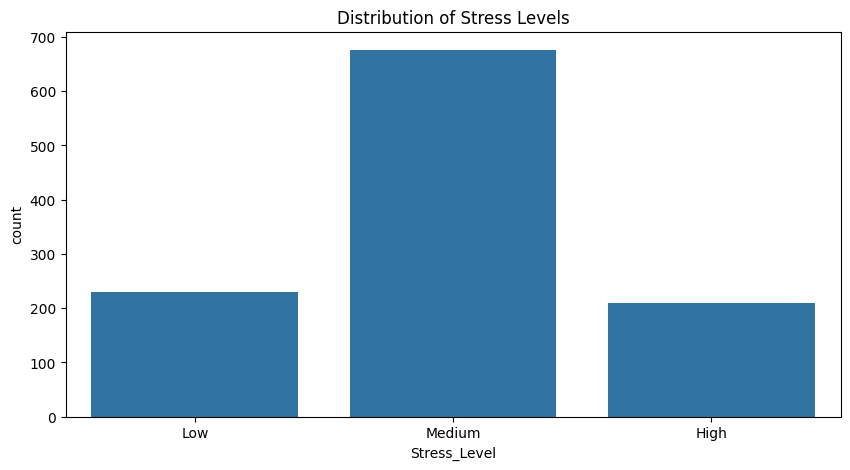

<Figure size 1200x500 with 0 Axes>

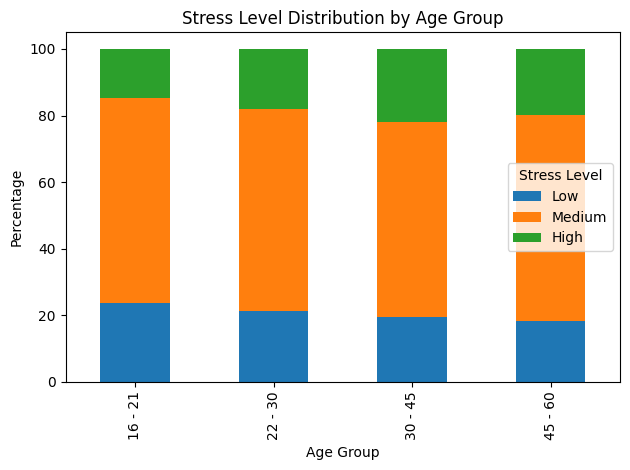

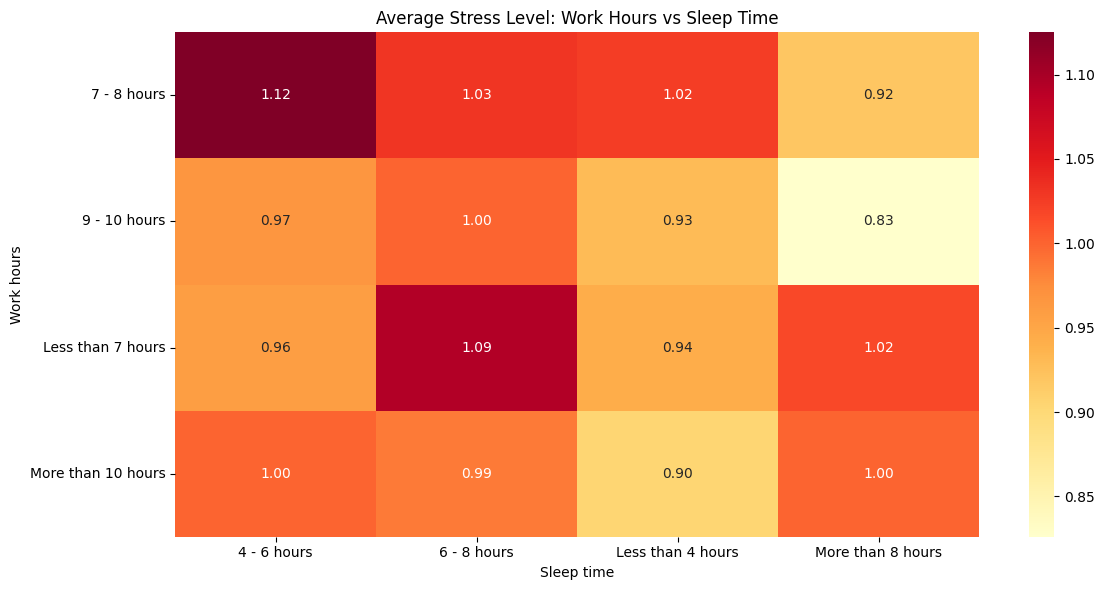

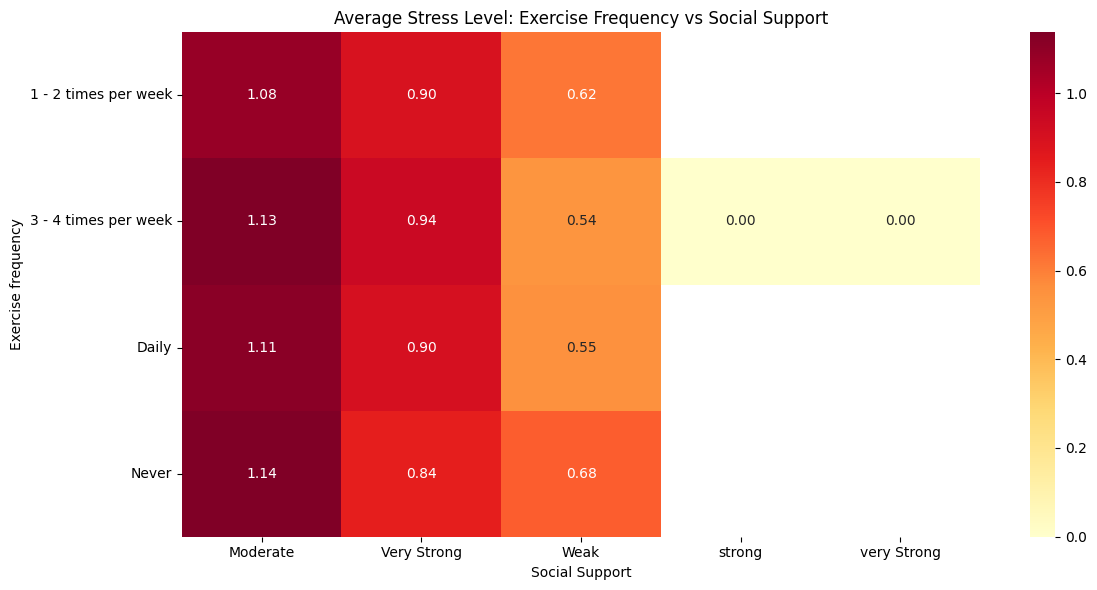

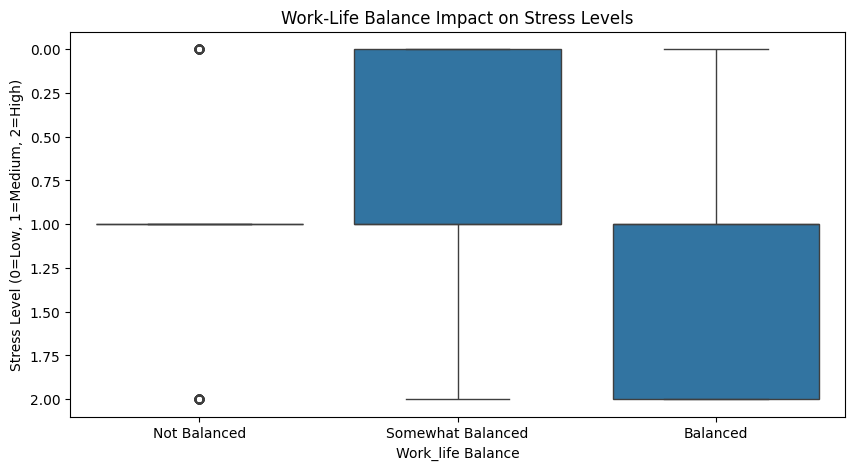

In [16]:
# Additional visualizations for lifestyle factors

# 1. Stress Level Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Stress_Level')
plt.title('Distribution of Stress Levels')
plt.show()

# 2. Stress Level by Age Group
plt.figure(figsize=(12, 5))
age_stress = pd.crosstab(df['Age'], df['Stress_Level'], normalize='index') * 100
age_stress.plot(kind='bar', stacked=True)
plt.title('Stress Level Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.legend(title='Stress Level')
plt.tight_layout()
plt.show()

# 3. Work Hours vs Sleep Time Impact
plt.figure(figsize=(12, 6))
stress_avg = pd.crosstab(
    index=df['Work hours'], 
    columns=df['Sleep time'],
    values=df['Stress_Level_Code'].astype('float'),
    aggfunc='mean'
)
sns.heatmap(stress_avg, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Average Stress Level: Work Hours vs Sleep Time')
plt.tight_layout()
plt.show()

# 4. Exercise and Social Support Impact
plt.figure(figsize=(12, 6))
exercise_social = pd.crosstab(
    index=df['Exercise frequency'], 
    columns=df['Social Support'],
    values=df['Stress_Level_Code'].astype('float'),
    aggfunc='mean'
)
sns.heatmap(exercise_social, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Average Stress Level: Exercise Frequency vs Social Support')
plt.tight_layout()
plt.show()

# 5. Work-Life Balance Impact on Stress
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Work_life Balance', y='Stress_Level_Code')
plt.title('Work-Life Balance Impact on Stress Levels')
plt.ylabel('Stress Level (0=Low, 1=Medium, 2=High)')
plt.show()

In [17]:
#hybrid model-optimized voting classifier
#voting strategy: soft voting(probability based)
#custom weights: RF=1.2, SVM=1.0(optimized for performance)
start_time_hybrid=time.time()


In [18]:
rf_optimized = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=15, n_jobs=-1, min_samples_split=5, min_samples_leaf=2)
svm_optimized = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)

In [19]:
#voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf', rf_optimized), ('svm', svm_optimized)],
    voting='soft',
    weights=[1.2, 1.0]
)

In [20]:
#cross validation for hybrid model
cv_scores_hybrid = cross_validate(voting_clf, X_train, y_train, cv=5,
                                 scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print("Cross-Validation Scores (5-Fold):")
print(f"  Accuracy: {cv_scores_hybrid['test_accuracy'].mean():.4f} (+/- {cv_scores_hybrid['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_scores_hybrid['test_precision_weighted'].mean():.4f} (+/- {cv_scores_hybrid['test_precision_weighted'].std():.4f})")
print(f"  Recall: {cv_scores_hybrid['test_recall_weighted'].mean():.4f} (+/- {cv_scores_hybrid['test_recall_weighted'].std():.4f})")
print(f"  F1-Score: {cv_scores_hybrid['test_f1_weighted'].mean():.4f} (+/- {cv_scores_hybrid['test_f1_weighted'].std():.4f})")


Cross-Validation Scores (5-Fold):
  Accuracy: 0.9394 (+/- 0.0210)
  Precision: 0.9422 (+/- 0.0191)
  Recall: 0.9394 (+/- 0.0210)
  F1-Score: 0.9386 (+/- 0.0217)


In [21]:
# Train hybrid model
voting_clf.fit(X_train, y_train)
y_pred_hybrid = voting_clf.predict(X_test)
hybrid_time = time.time() - start_time_hybrid

print(f"\nTest Set Performance:")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_hybrid):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_hybrid, average='weighted'):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_hybrid, average='weighted'):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_hybrid, average='weighted'):.4f}")

print(f"\nTotal Training Time: {hybrid_time:.4f} seconds")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_hybrid, target_names=['Low', 'Medium', 'High']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_hybrid))


Test Set Performance:
  Accuracy: 0.9507
  Precision: 0.9507
  Recall: 0.9507
  F1-Score: 0.9505

Total Training Time: 2.1415 seconds

Detailed Classification Report:
              precision    recall  f1-score   support

         Low       0.95      0.93      0.94        45
      Medium       0.95      0.97      0.96       134
        High       0.95      0.91      0.93        44

    accuracy                           0.95       223
   macro avg       0.95      0.94      0.94       223
weighted avg       0.95      0.95      0.95       223


Confusion Matrix:
[[ 42   3   0]
 [  2 130   2]
 [  0   4  40]]


In [22]:
#comprehensive model comparision
comparison_results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'Hybrid Ensemble (RF + SVM)'],
    'CV Accuracy': [
        cv_scores_rf['test_accuracy'].mean(),
        cv_scores_svm['test_accuracy'].mean(),
        cv_scores_hybrid['test_accuracy'].mean()
    ],
    'CV Std Dev': [
        cv_scores_rf['test_accuracy'].std(),
        cv_scores_svm['test_accuracy'].std(),
        cv_scores_hybrid['test_accuracy'].std()
    ],
    'Test Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_hybrid)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_svm, average='weighted'),
        precision_score(y_test, y_pred_hybrid, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_svm, average='weighted'),
        recall_score(y_test, y_pred_hybrid, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted'),
        f1_score(y_test, y_pred_hybrid, average='weighted')
    ],
    'Training Time (s)': [rf_time, svm_time, hybrid_time]
})

print("\n", comparison_results.to_string(index=False))


                      Model  CV Accuracy  CV Std Dev  Test Accuracy  Precision   Recall  F1-Score  Training Time (s)
             Random Forest     0.865319    0.009406       0.892377   0.894067 0.892377  0.891212           1.422737
                       SVM     0.928203    0.024842       0.964126   0.964483 0.964126  0.963977           0.196835
Hybrid Ensemble (RF + SVM)     0.939426    0.021002       0.950673   0.950729 0.950673  0.950507           2.141550


In [23]:
#identifying best model
best_idx = comparison_results['Test Accuracy'].idxmax()
print(f"\n✓ BEST MODEL: {comparison_results.loc[best_idx, 'Model']}")
print(f"  Accuracy: {comparison_results.loc[best_idx, 'Test Accuracy']:.4f}")
print(f"  Training Time: {comparison_results.loc[best_idx, 'Training Time (s)']:.4f}s")



✓ BEST MODEL: SVM
  Accuracy: 0.9641
  Training Time: 0.1968s


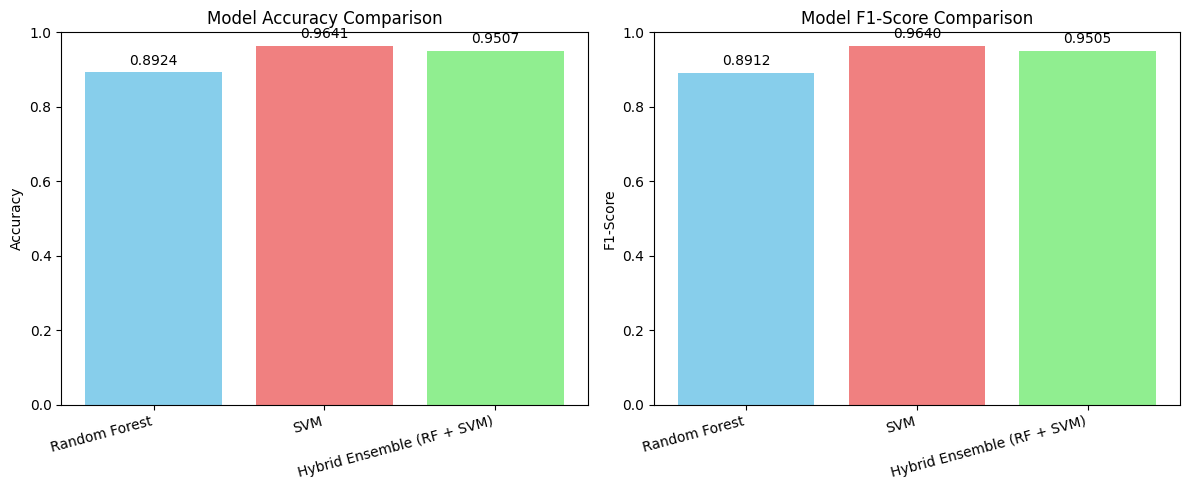

In [33]:
# Visual Comparison of Models

models = comparison_results['Model']
x_pos = np.arange(len(models))
colors = ['skyblue', 'lightcoral', 'lightgreen']  # Hybrid model highlighted

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy Comparison
axes[0].bar(x_pos, comparison_results['Test Accuracy'], color=colors)
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].set_ylim(0, 1)
for i, v in enumerate(comparison_results['Test Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center')

# F1-Score Comparison
axes[1].bar(x_pos, comparison_results['F1-Score'], color=colors)
axes[1].set_title('Model F1-Score Comparison')
axes[1].set_ylabel('F1-Score')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].set_ylim(0, 1)
for i, v in enumerate(comparison_results['F1-Score']):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()


In [25]:
#Training Time Comparison - Shows improvement
ax3 = axes[1, 0]
ax3.bar(x_pos, comparison_results['Training Time (s)'], color=colors)
ax3.set_ylabel('Time (seconds)')
ax3.set_title('Model Training Time Comparison\n(Lower is Better)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(models, rotation=15, ha='right')
for i, v in enumerate(comparison_results['Training Time (s)']):
    ax3.text(i, v + 0.001, f'{v:.4f}s', ha='center')

In [26]:
#Precision vs Recall - Shows balanced performance
ax4 = axes[1, 1]
x_pos_grouped = np.arange(len(models))
width = 0.35
ax4.bar(x_pos_grouped - width/2, comparison_results['Precision'], width, label='Precision', color='orange')
ax4.bar(x_pos_grouped + width/2, comparison_results['Recall'], width, label='Recall', color='purple')
ax4.set_ylabel('Score')
ax4.set_title('Precision vs Recall Comparison')
ax4.set_xticks(x_pos_grouped)
ax4.set_xticklabels(models, rotation=15, ha='right')
ax4.legend()
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

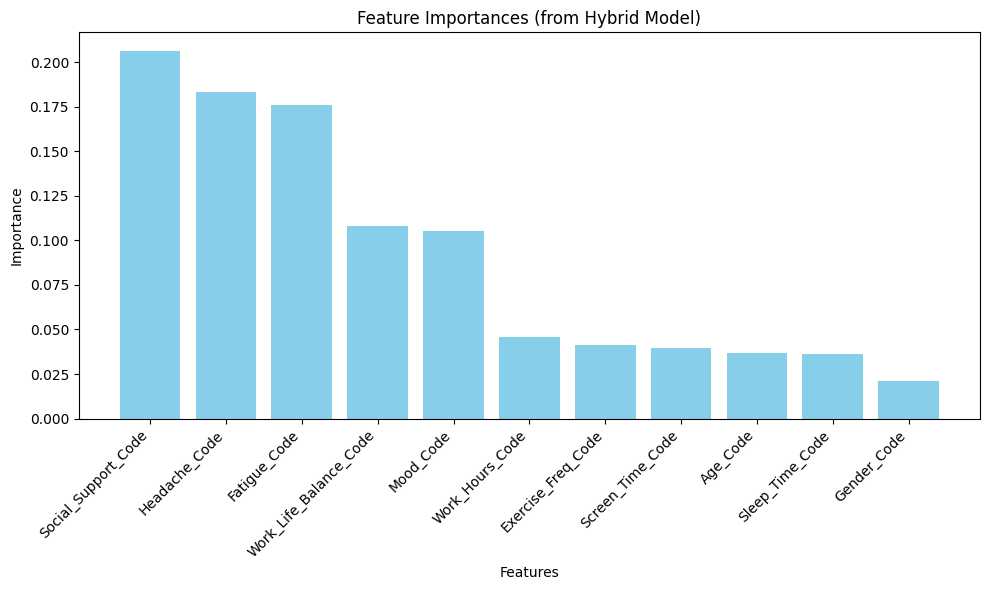


Feature Importances:
Social_Support_Code: 0.2064
Headache_Code: 0.1835
Fatigue_Code: 0.1761
Work_Life_Balance_Code: 0.1079
Mood_Code: 0.1054
Work_Hours_Code: 0.0459
Exercise_Freq_Code: 0.0413
Screen_Time_Code: 0.0397
Age_Code: 0.0368
Sleep_Time_Code: 0.0360
Gender_Code: 0.0210


In [27]:
#Feature Importance from Hybrid Model
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': voting_clf.estimators_[0].feature_importances_
})

feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.title('Feature Importances (from Hybrid Model)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nFeature Importances:")
for idx, row in feature_importances.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

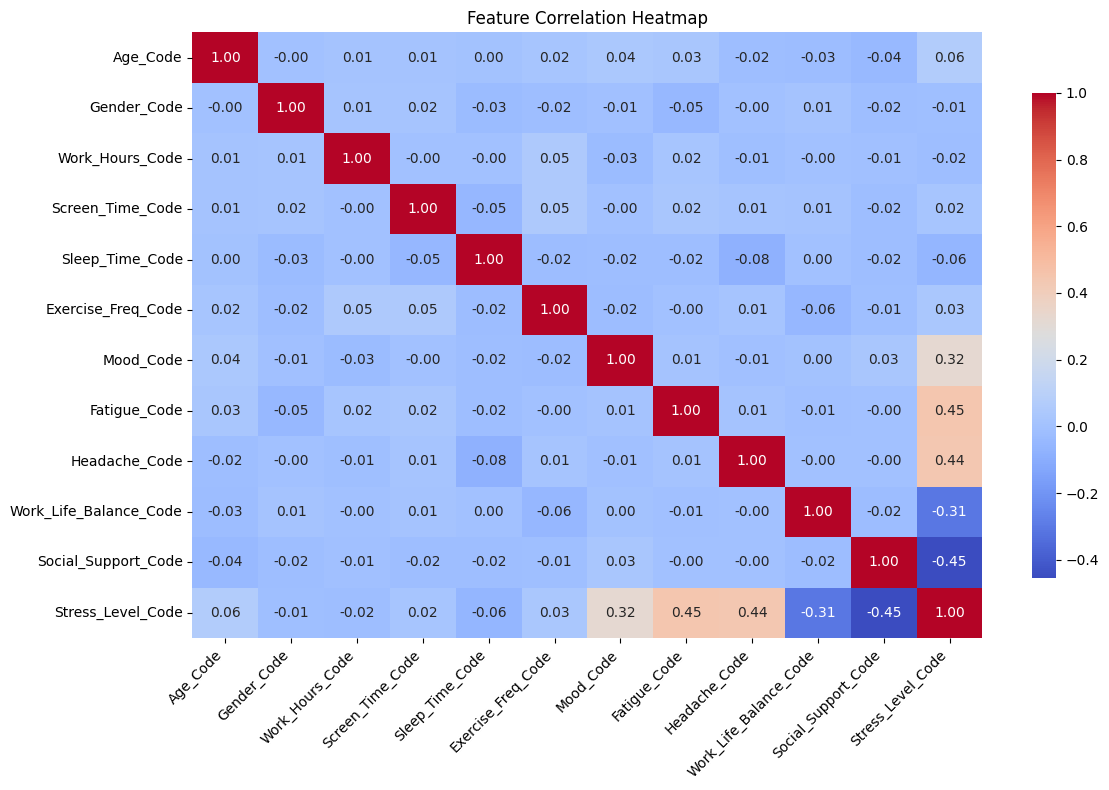


Strongest correlations with Stress Level:
Stress_Level_Code         1.000000
Fatigue_Code              0.446336
Headache_Code             0.440624
Mood_Code                 0.321178
Age_Code                  0.063987
Exercise_Freq_Code        0.031045
Screen_Time_Code          0.022588
Gender_Code              -0.014116
Work_Hours_Code          -0.016863
Sleep_Time_Code          -0.056661
Work_Life_Balance_Code   -0.311259
Social_Support_Code      -0.453570
Name: Stress_Level_Code, dtype: float64


In [28]:
#Feature Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df[features + ['Stress_Level_Code']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

correlations = correlation_matrix['Stress_Level_Code'].sort_values(ascending=False)
print("\nStrongest correlations with Stress Level:")
print(correlations)

In [29]:
#Export Mappings and Model

mappings = {
    'age_map': {'16 - 21': 0, '22 - 30': 1, '30 - 45': 2, '45 - 60': 3},
    'gender_map': {'Male': 0, 'Female': 1},
    'work_hours_map': {'Less than 7 hours': 0, '7 - 8 hours': 1, '9 - 10 hours': 2, 'More than 10 hours': 3},
    'screen_time_map': {'Less than 2 hours': 0, '2 - 4 hours': 1, '4 - 6 hours': 2, 'More than 6 hours': 3},
    'sleep_time_map': {'Less than 4 hours': 0, '4 - 6 hours': 1, '6 - 8 hours': 2, 'More than 8 hours': 3},
    'exercise_freq_map': {'Never': 0, '1 - 2 times per week': 1, '3 - 4 times per week': 2, 'Daily': 3},
    'mood_map': {'Unstable': 0, 'Neutral': 1, 'Stable': 2},
    'fatigue_map': {'Never tired': 0, 'Occasionally tired': 1, 'Often tired': 2, 'Exhausted': 3},
    'headache_map': {'Never': 0, 'Rarely': 1, 'Sometimes (1 - 2 times/ week)': 2, 'Frequently (more than twice in a week)': 3},
    'work_life_balance_map': {'Not Balanced': 0, 'Somewhat Balanced': 1, 'Balanced': 2},
    'social_support_map': {'None': 0, 'Weak': 1, 'Moderate': 2, 'Very Strong': 3},
    'reverse_mappings': {
        'age': {0: '16 - 21', 1: '22 - 30', 2: '30 - 45', 3: '45 - 60'},
        'gender': {0: 'Male', 1: 'Female'},
        'work_hours': {0: 'Less than 7 hours', 1: '7 - 8 hours', 2: '9 - 10 hours', 3: 'More than 10 hours'},
        'screen_time': {0: 'Less than 2 hours', 1: '2 - 4 hours', 2: '4 - 6 hours', 3: 'More than 6 hours'},
        'sleep_time': {0: 'Less than 4 hours', 1: '4 - 6 hours', 2: '6 - 8 hours', 3: 'More than 8 hours'},
        'exercise_freq': {0: 'Never', 1: '1 - 2 times per week', 2: '3 - 4 times per week', 3: 'Daily'},
        'mood': {0: 'Unstable', 1: 'Neutral', 2: 'Stable'},
        'fatigue': {0: 'Never tired', 1: 'Occasionally tired', 2: 'Often tired', 3: 'Exhausted'},
        'headache': {0: 'Never', 1: 'Rarely', 2: 'Sometimes (1 - 2 times/ week)', 3: 'Frequently (more than twice in a week)'},
        'work_life_balance': {0: 'Not Balanced', 1: 'Somewhat Balanced', 2: 'Balanced'},
        'social_support': {0: 'None', 1: 'Weak', 2: 'Moderate', 3: 'Very Strong'}
    }
}

with open('mappings.json', 'w') as f:
    json.dump(mappings, f, indent=4)

print("Mappings exported to 'mappings.json'")

Mappings exported to 'mappings.json'


In [30]:
#Sample Prediction with Hybrid Model

sample = pd.DataFrame({
    'Age_Code': [2],
    'Gender_Code': [0],
    'Work_Hours_Code': [2],
    'Screen_Time_Code': [2],
    'Sleep_Time_Code': [2],
    'Exercise_Freq_Code': [2],
    'Mood_Code': [2],
    'Fatigue_Code': [1],
    'Headache_Code': [1],
    'Work_Life_Balance_Code': [2],
    'Social_Support_Code': [3]
})

predicted_code = voting_clf.predict(sample)[0]
predicted_proba = voting_clf.predict_proba(sample)[0]
stress_map = {0: 'Low', 1: 'Medium', 2: 'High'}

print(f"\nPredicted Stress Level: {stress_map[predicted_code]}")
print(f"\nPrediction Confidence Scores:")
for i, stress_level in enumerate(['Low', 'Medium', 'High']):
    print(f"  {stress_level}: {predicted_proba[i]:.4f}")

print("\nSample Person Profile:")
print(f"Age: {mappings['reverse_mappings']['age'][sample['Age_Code'].iloc[0]]}")
print(f"Gender: {mappings['reverse_mappings']['gender'][sample['Gender_Code'].iloc[0]]}")
print(f"Work Hours: {mappings['reverse_mappings']['work_hours'][sample['Work_Hours_Code'].iloc[0]]}")
print(f"Screen Time: {mappings['reverse_mappings']['screen_time'][sample['Screen_Time_Code'].iloc[0]]}")
print(f"Sleep Time: {mappings['reverse_mappings']['sleep_time'][sample['Sleep_Time_Code'].iloc[0]]}")
print(f"Exercise Frequency: {mappings['reverse_mappings']['exercise_freq'][sample['Exercise_Freq_Code'].iloc[0]]}")
print(f"Mood Stability: {mappings['reverse_mappings']['mood'][sample['Mood_Code'].iloc[0]]}")
print(f"Fatigue Level: {mappings['reverse_mappings']['fatigue'][sample['Fatigue_Code'].iloc[0]]}")
print(f"Headache Frequency: {mappings['reverse_mappings']['headache'][sample['Headache_Code'].iloc[0]]}")
print(f"Work-Life Balance: {mappings['reverse_mappings']['work_life_balance'][sample['Work_Life_Balance_Code'].iloc[0]]}")
print(f"Social Support: {mappings['reverse_mappings']['social_support'][sample['Social_Support_Code'].iloc[0]]}")



Predicted Stress Level: Low

Prediction Confidence Scores:
  Low: 0.8055
  Medium: 0.1944
  High: 0.0001

Sample Person Profile:
Age: 30 - 45
Gender: Male
Work Hours: 9 - 10 hours
Screen Time: 4 - 6 hours
Sleep Time: 6 - 8 hours
Exercise Frequency: 3 - 4 times per week
Mood Stability: Stable
Fatigue Level: Occasionally tired
Headache Frequency: Rarely
Work-Life Balance: Balanced
Social Support: Very Strong


C:\Users\rasgu\AppData\Local\Temp\ipykernel_53040\3188715765.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Stress_Level', palette='Set2')


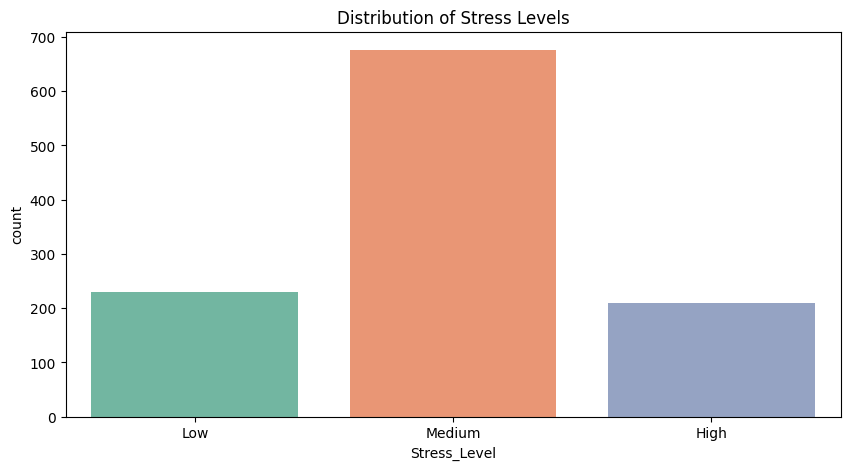

<Figure size 1200x500 with 0 Axes>

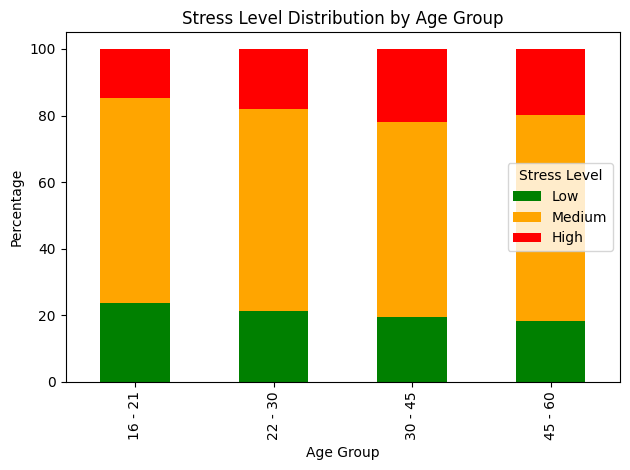

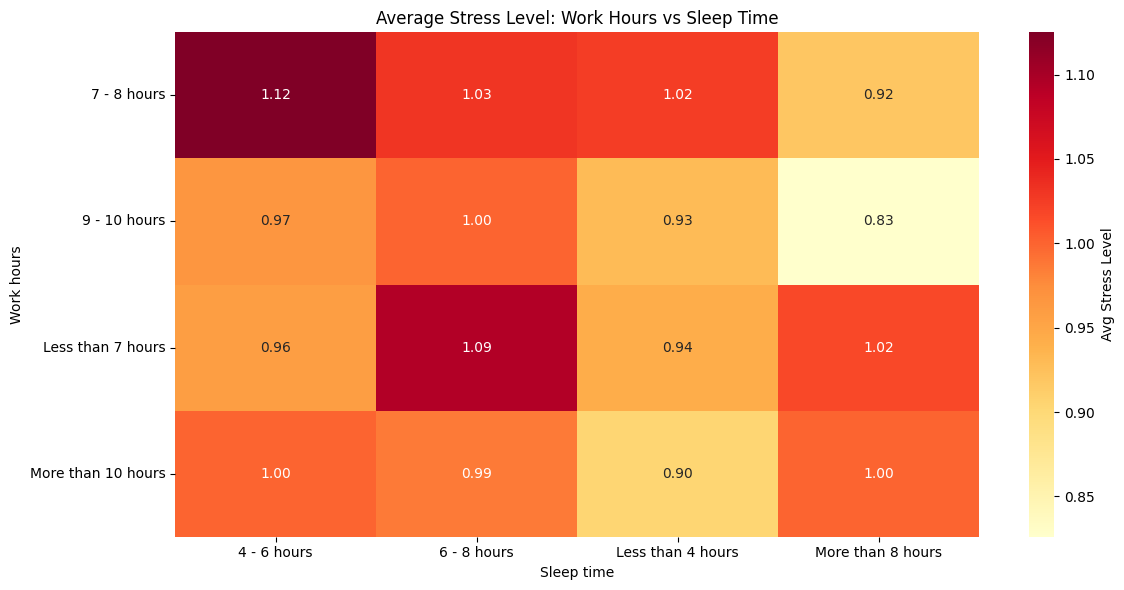

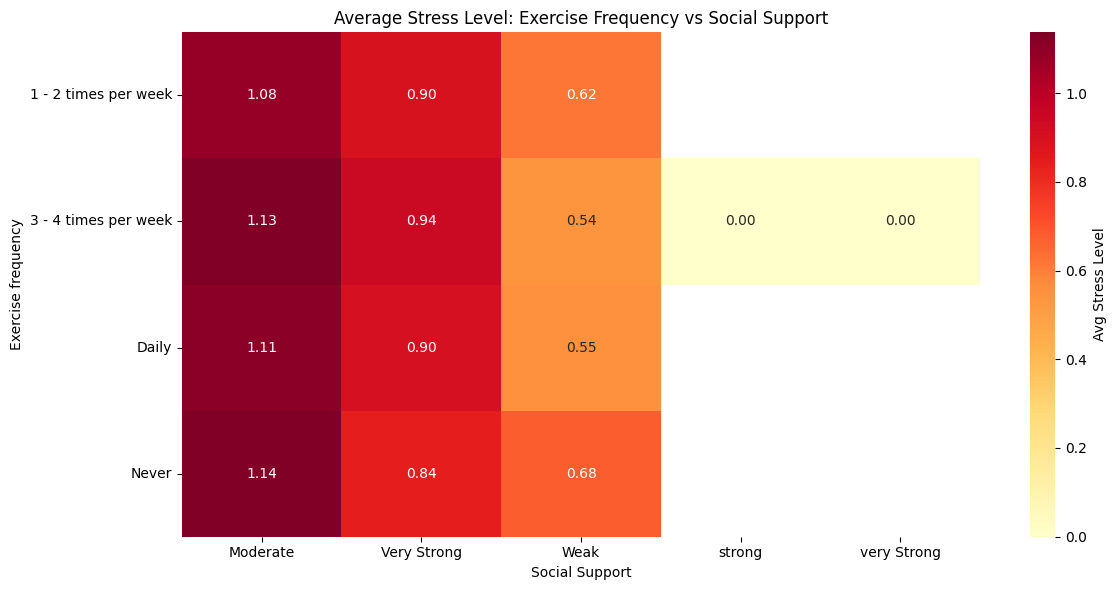

C:\Users\rasgu\AppData\Local\Temp\ipykernel_53040\3188715765.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Work_life Balance', y='Stress_Level_Code', palette='Set2')


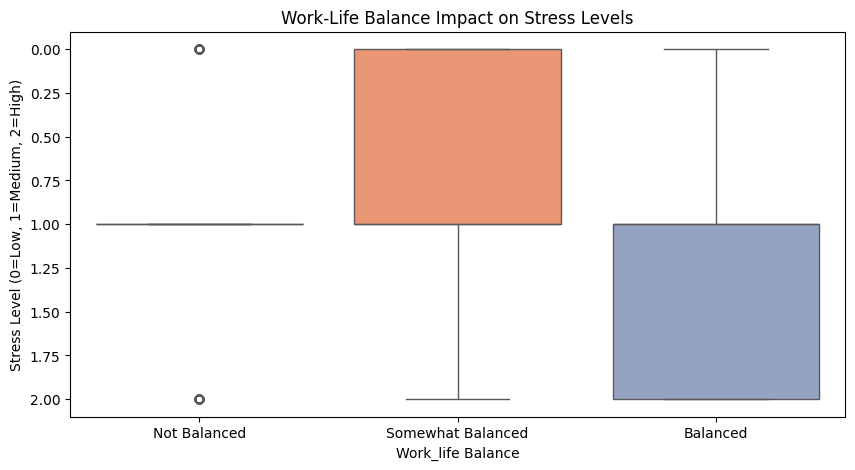

In [31]:
#Additional Lifestyle Visualizations

# 1. Stress Level Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Stress_Level', palette='Set2')
plt.title('Distribution of Stress Levels')
plt.show()

# 2. Stress Level by Age Group
plt.figure(figsize=(12, 5))
age_stress = pd.crosstab(df['Age'], df['Stress_Level'], normalize='index') * 100
age_stress.plot(kind='bar', stacked=True, color=['green', 'orange', 'red'])
plt.title('Stress Level Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.legend(title='Stress Level')
plt.tight_layout()
plt.show()

# 3. Work Hours vs Sleep Time Impact
plt.figure(figsize=(12, 6))
stress_avg = pd.crosstab(
    index=df['Work hours'], 
    columns=df['Sleep time'],
    values=df['Stress_Level_Code'].astype('float'),
    aggfunc='mean'
)
sns.heatmap(stress_avg, annot=True, cmap='YlOrRd', fmt='.2f', cbar_kws={'label': 'Avg Stress Level'})
plt.title('Average Stress Level: Work Hours vs Sleep Time')
plt.tight_layout()
plt.show()

# 4. Exercise and Social Support Impact
plt.figure(figsize=(12, 6))
exercise_social = pd.crosstab(
    index=df['Exercise frequency'], 
    columns=df['Social Support'],
    values=df['Stress_Level_Code'].astype('float'),
    aggfunc='mean'
)
sns.heatmap(exercise_social, annot=True, cmap='YlOrRd', fmt='.2f', cbar_kws={'label': 'Avg Stress Level'})
plt.title('Average Stress Level: Exercise Frequency vs Social Support')
plt.tight_layout()
plt.show()

# 5. Work-Life Balance Impact on Stress
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Work_life Balance', y='Stress_Level_Code', palette='Set2')
plt.title('Work-Life Balance Impact on Stress Levels')
plt.ylabel('Stress Level (0=Low, 1=Medium, 2=High)')
plt.show()